In [100]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox

In [2]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

# Отображение графиков

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

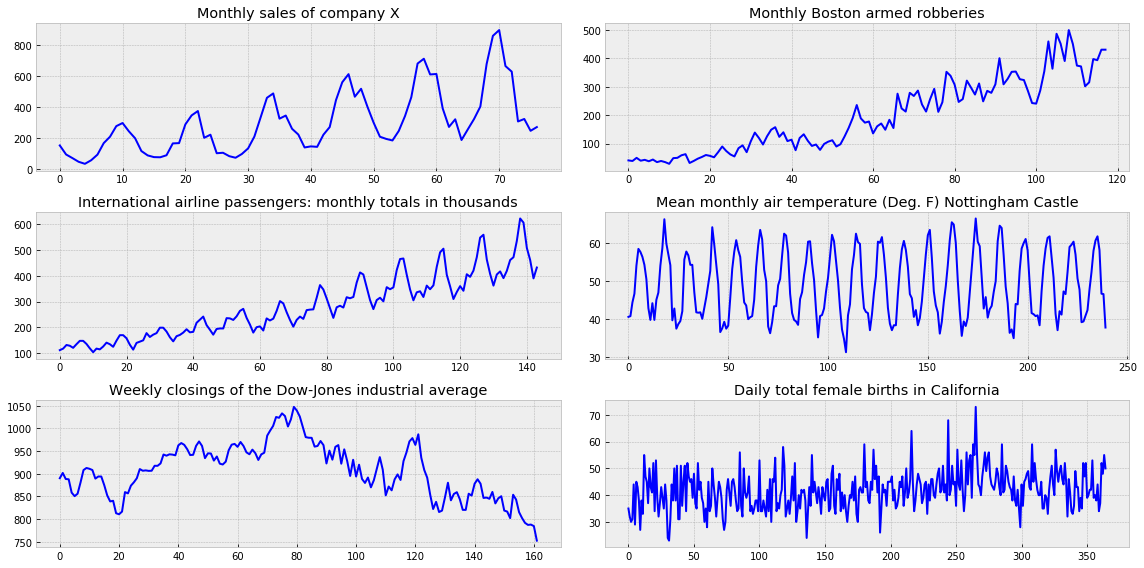

In [6]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2 # 
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Тест Дики-Фуллера 

In [77]:
################
# Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Коррелограммы

In [121]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', start_point=0, step=0):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

#        y.plot(ax=ts_ax, color='blue', label='Or')
        plot_ts_and_points(y, start_point, step, ts_ax)
        
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# Поиск сезонности

In [90]:
def plot_ts_and_points(ts, start_point, step, ts_ax):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
#        plt.figure(figsize=(14, 8))
#        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')
        new_series.plot(ax=ts_ax, style='ro')

# Исследование и приведение к стационарности

### Monthly sales of company X

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


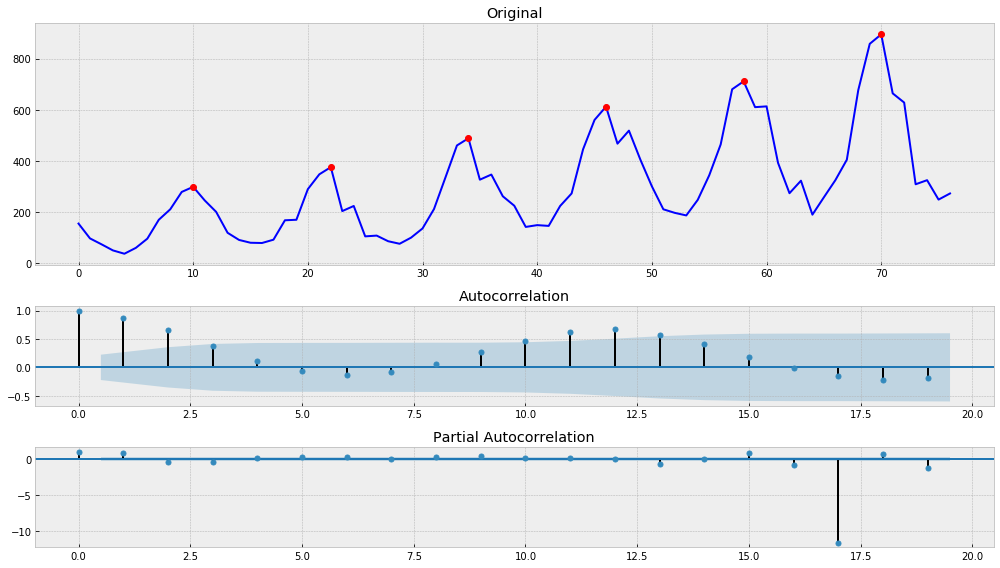

In [91]:
series_1 = all_series["Monthly sales of company X"]
#plot_ts_and_points(series_1, 10, 12)
tsplot(series_1, start_point = 10, step = 12)

Сезонность очевидна. Также есть тренд со смещением и размаху дисперсии.
Тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда.

#### Уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [93]:
series_1 = boxcox(series_1, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


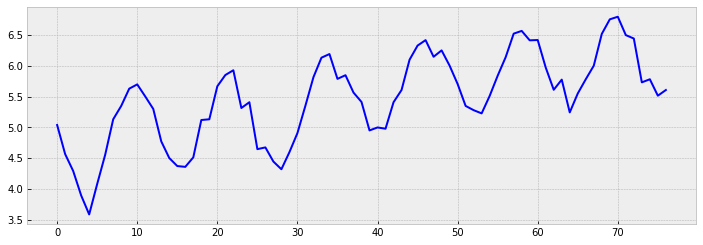

In [99]:
test_stationarity(series_1)

with plt.style.context('bmh'):
        plt.figure(figsize=(12, 4))
        plt.plot(series_1, color='blue')

#### Уберем тренд дифференцированием

In [101]:
series_1 = np.diff(series_1, 1)

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


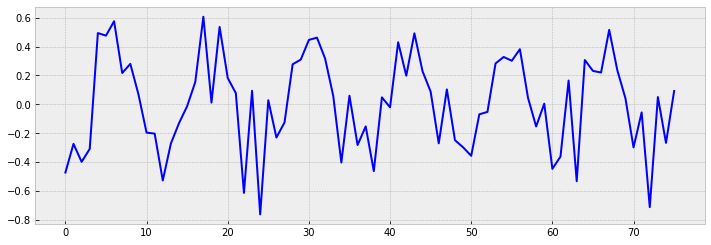

In [102]:
test_stationarity(series_1)

with plt.style.context('bmh'):
        plt.figure(figsize=(12, 4))
        plt.plot(series_1, color='blue')

#### Уберем сезонность

In [113]:
series_1 = series_1[2:] - series_1[:-2]

Results of Dickey-Fuller Test:
Test Statistic                 -4.516198
p-value                         0.000184
#Lags Used                      9.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


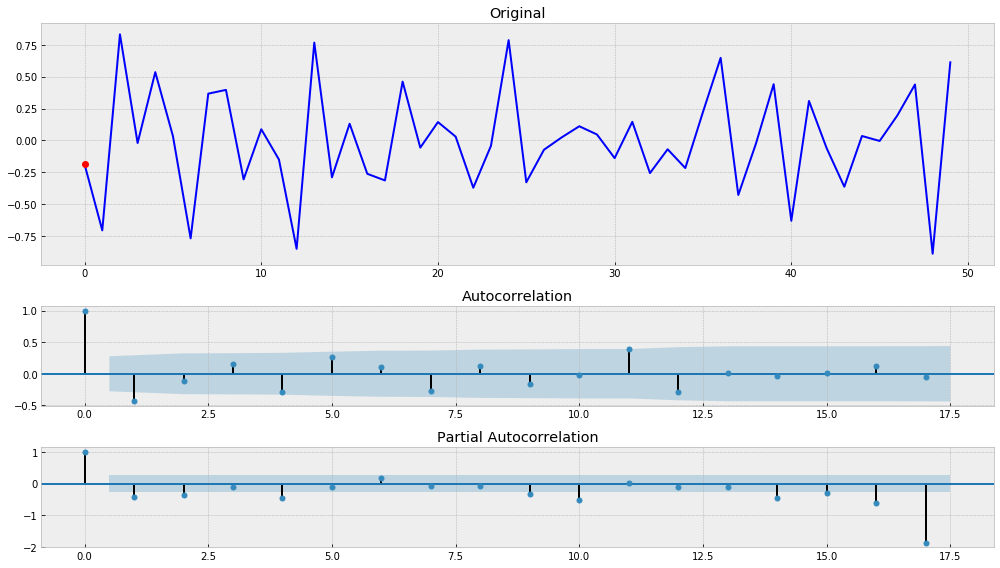

In [122]:
tsplot(series_1)

In [115]:
#Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда

### Monthly Boston armed robberies

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


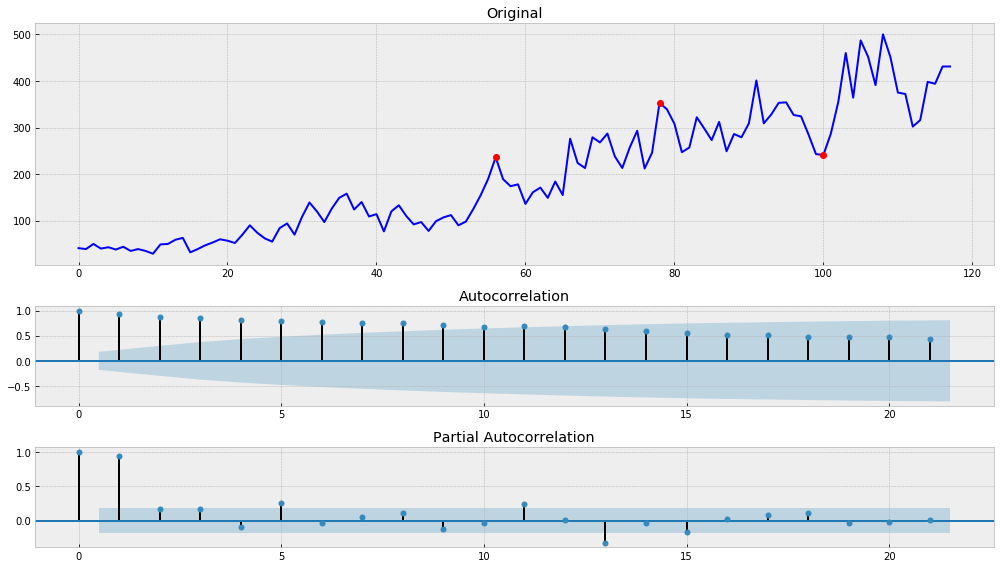

In [160]:
series_2 = all_series["Monthly Boston armed robberies"]
tsplot(series_2, start_point = 56, step = 22)

In [128]:
#Сезонность не просматривается, возмно есть не ярко выраженная цикличность. Очевидно наличие тренда.

#### Уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [161]:
series_2 = boxcox(series_2, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


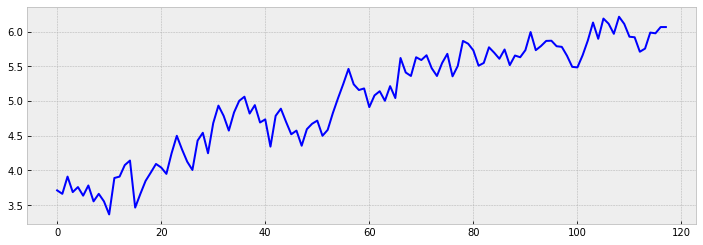

In [162]:
test_stationarity(series_2)

with plt.style.context('bmh'):
        plt.figure(figsize=(12, 4))
        plt.plot(series_2, color='blue')

#### Уберем тренд дифференцированием

In [163]:
series_2 = np.diff(series_2, 1)

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


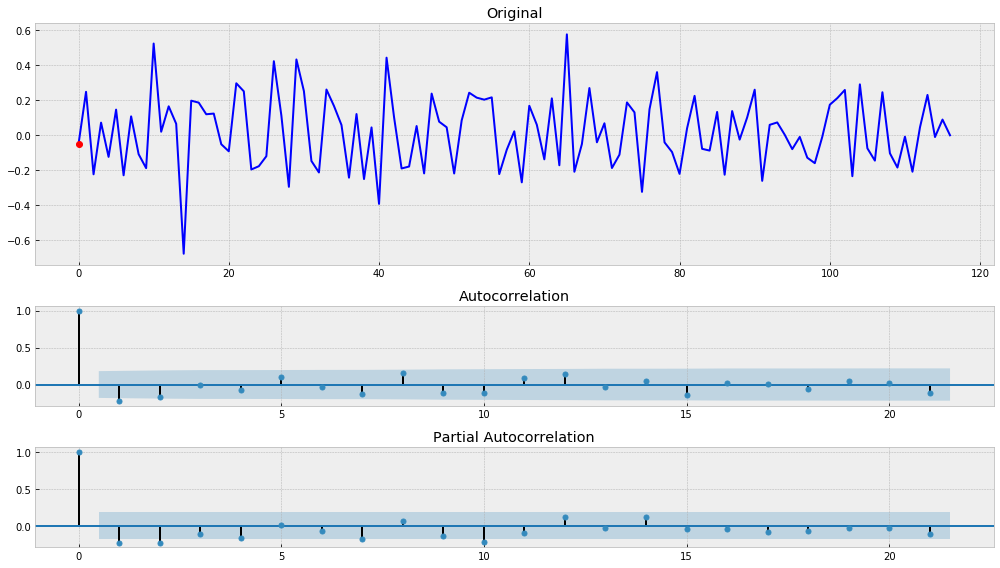

In [164]:
tsplot(series_2)

In [129]:
#Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда

### International airline passengers: monthly totals in thousands

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


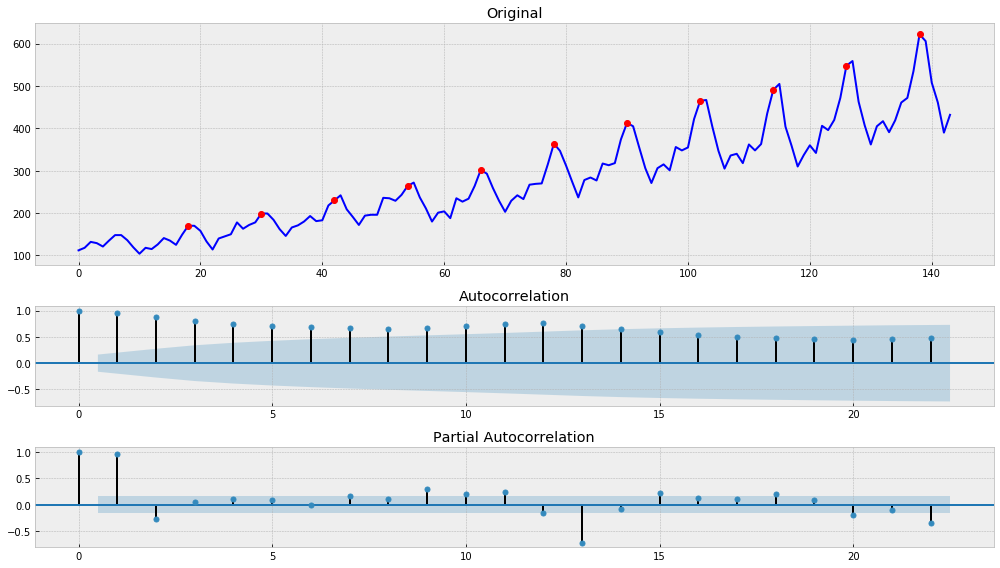

In [196]:
series_3 = all_series["International airline passengers: monthly totals in thousands"]
tsplot(series_3, start_point = 18, step = 12)

Сезонность очевидна. Также есть тренд со смещением и размаху дисперсии

#### Уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [197]:
series_3 = boxcox(series_3, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


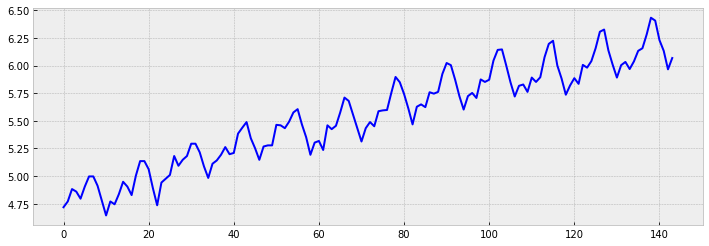

In [198]:
test_stationarity(series_3)

with plt.style.context('bmh'):
        plt.figure(figsize=(12, 4))
        plt.plot(series_3, color='blue')

#### Уберем тренд дифференцированием

In [199]:
series_3 = np.diff(series_3, 1)

Results of Dickey-Fuller Test:
Test Statistic                 -4.516198
p-value                         0.000184
#Lags Used                      9.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


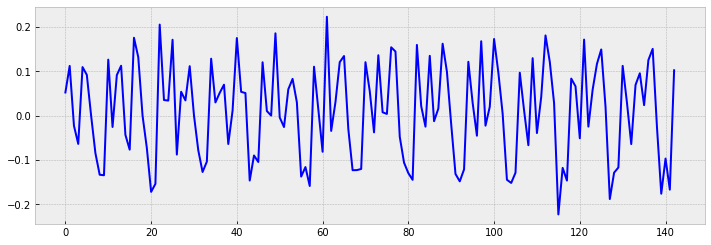

In [200]:
test_stationarity(series_1)

with plt.style.context('bmh'):
        plt.figure(figsize=(12, 4))
        plt.plot(series_3, color='blue')

#### Уберем сезонность

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


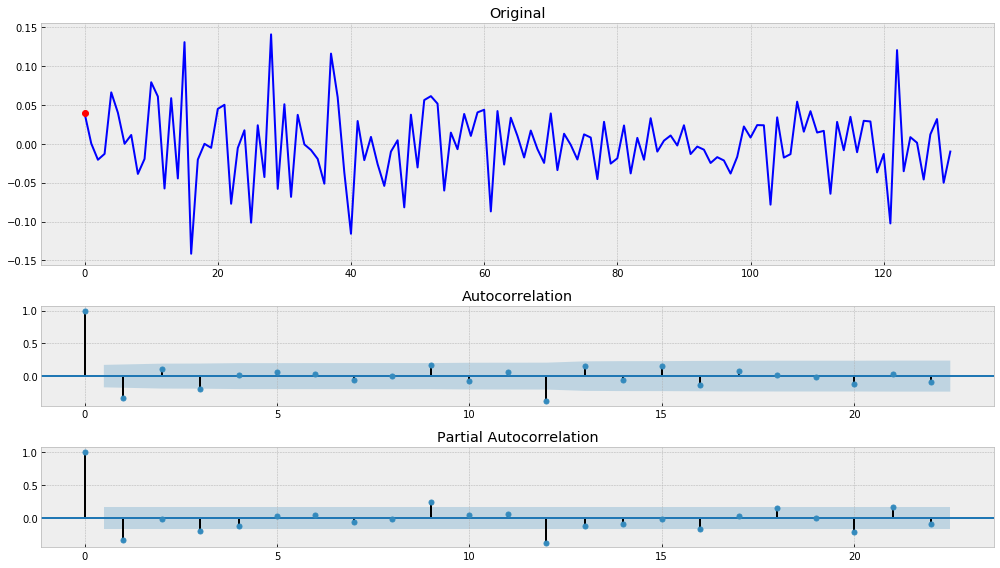

In [201]:
a = 12
series_3 = series_3[a:] - series_3[:-a]
tsplot(series_3)

In [171]:
#Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда

### Mean monthly air temperature (Deg. F) Nottingham Castle

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


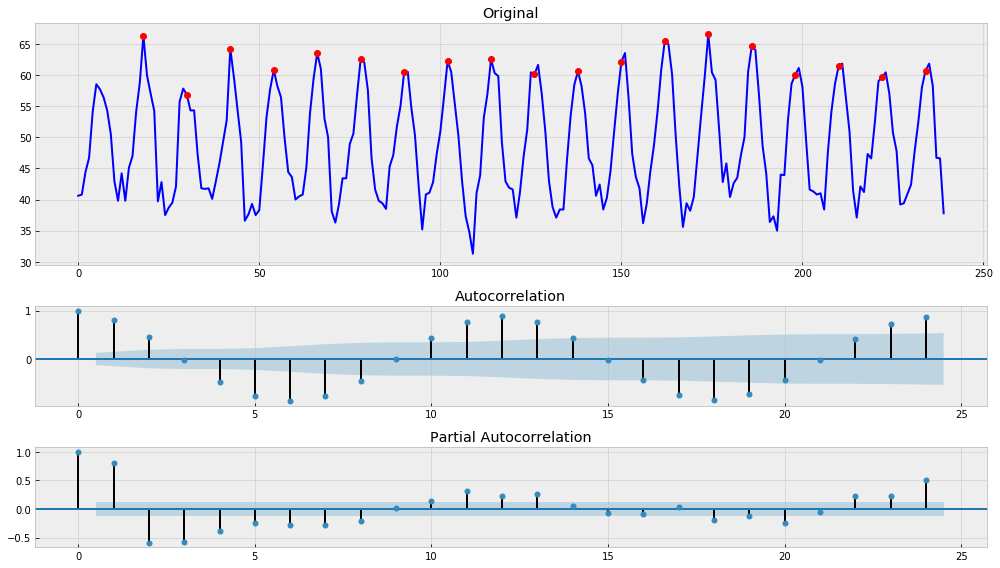

In [209]:
series_4 = all_series["Mean monthly air temperature (Deg. F) Nottingham Castle"]
tsplot(series_4, start_point = 18, step = 12)

Сезонность очевидна. Тренд не обнаружен.

#### Уберем сезонность

Results of Dickey-Fuller Test:
Test Statistic                -6.072501e+00
p-value                        1.141945e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


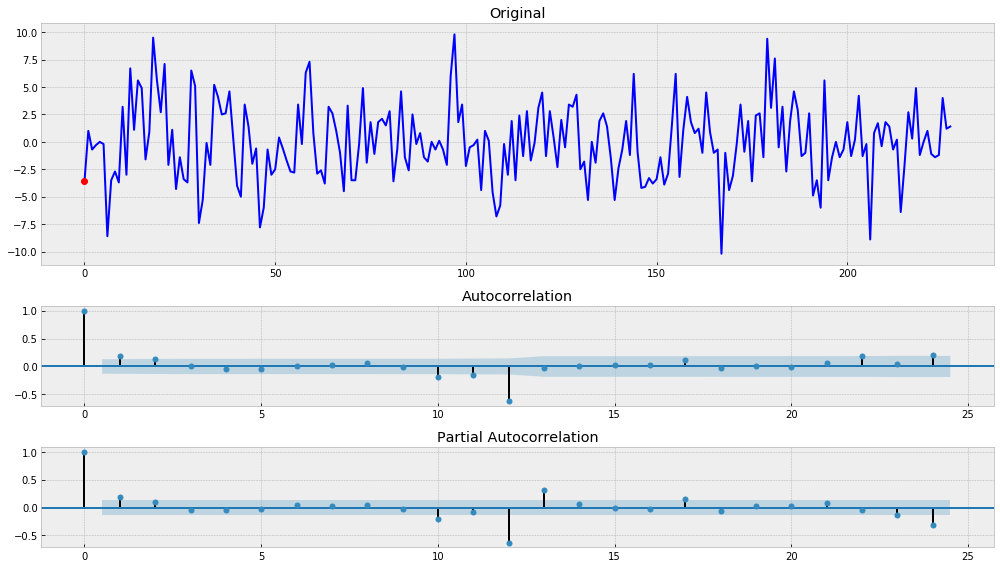

In [215]:
series_4_0 = []

for i in range(len(series_4)):
    if i+12 == 240:
        break
        
    c = series_4[i] - series_4[i+12]
    series_4_0.append(c)

tsplot(series_4_0)

In [ ]:
#Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда

### Weekly closings of the Dow-Jones industrial average

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


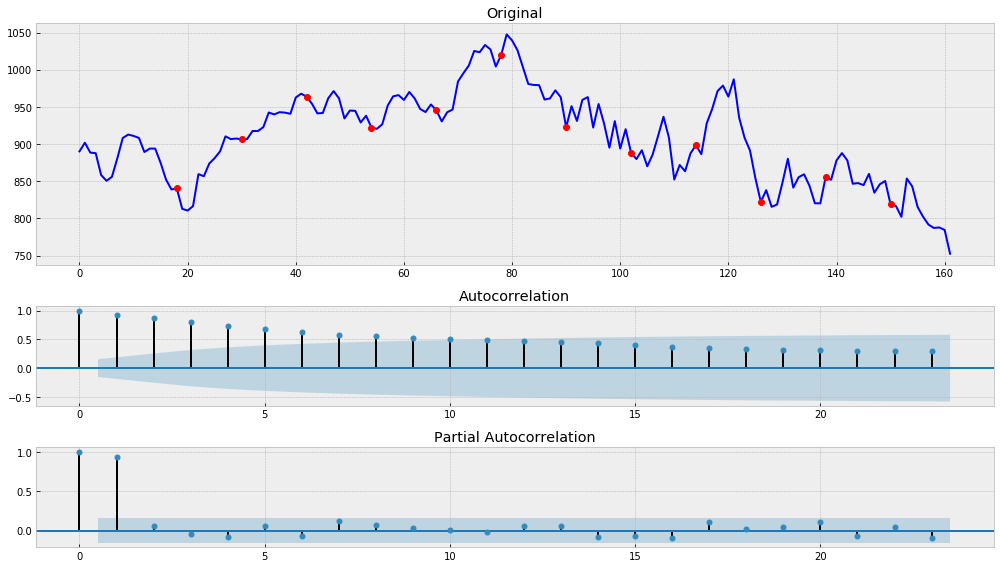

In [216]:
series_5 = all_series["Weekly closings of the Dow-Jones industrial average"]
tsplot(series_5, start_point = 18, step = 12)

Сезонность не обнаружена. Тренд послеживается после 80 значения, но возможно носит более сложный характер.
Ряд нестационарный

#### Уберем тренд дифференцированием

Results of Dickey-Fuller Test:
Test Statistic                  -5.099378
p-value                          0.000014
#Lags Used                      14.000000
Number of Observations Used    145.000000
Critical Value (1%)             -3.476273
Critical Value (5%)             -2.881688
Critical Value (10%)            -2.577513
dtype: float64


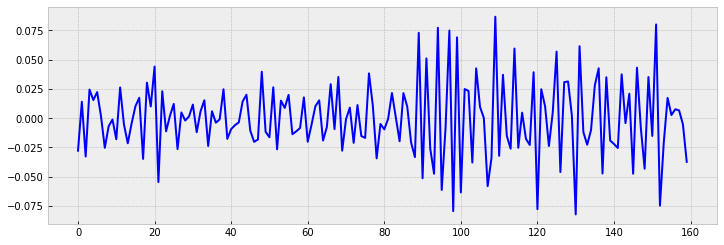

In [222]:
series_5 = np.diff(series_5, 1)

test_stationarity(series_5)
with plt.style.context('bmh'):
        plt.figure(figsize=(12, 4))
        plt.plot(series_5, color='blue')

In [ ]:
#Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда

### Daily total female births in California

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


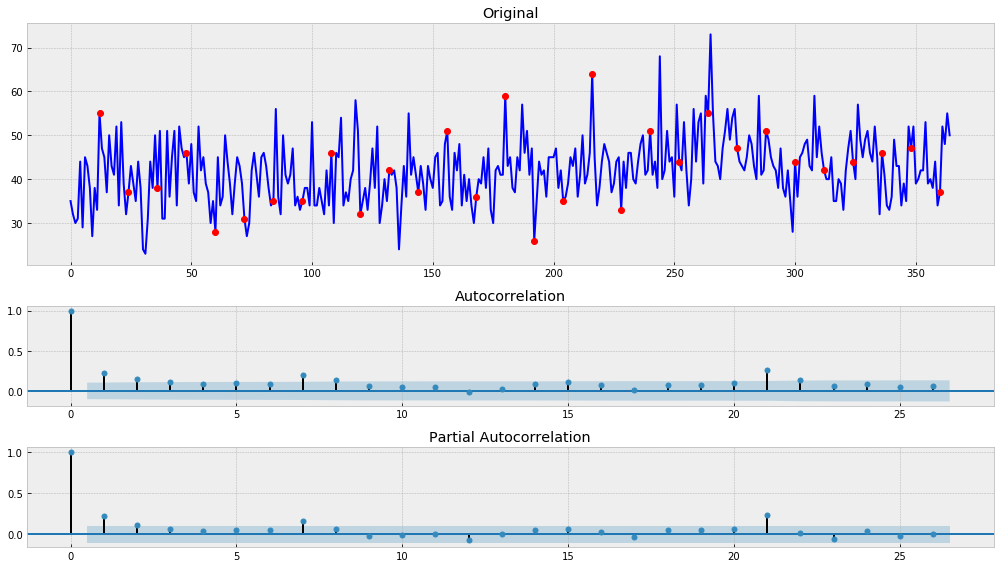

In [226]:
series_6 = all_series["Daily total female births in California"]
tsplot(series_6, start_point = 12, step = 12)

#Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда